In [2]:
from sympy import symbols, lambdify, sin, cos, tanh, exp, log, Max
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import _cntr as cntr
from mpl_toolkits.mplot3d import Axes3D
import math
import time
from ipywidgets import interact
from ipywidgets import widgets

class warper:
    
    def __init__(self):
        a = 0
        self.orig_data = []
        self.transformed_data = []
        self.original_separator = []
        self.transformed_separator = []
        self.labels = []
        self.ind0 = []
        self.ind1 = []
        self.grid = []
        
    # define the user-defined transformation in numpy
    def define_rule(self,rule1,rule2):
        self.rule1 = lambdify((x1,x2),rule1,np)
        self.rule2 = lambdify((x1,x2),rule2,np)

    # transform data bsaed on user-defined transformations
    def make_rule(self,data):
        s = data[:,0]
        t = data[:,1]

        ## transform space - each axes - via net transform    
        f1 = self.rule1(s,t)
        f1.shape = (len(f1),1)

        # transform using basis element 2
        f2 = self.rule2(s,t)
        f2.shape = (len(f2),1)

        return f1,f2
    
    # create points based on user-defined transformations
    def make_pts(self):
        # generate datapoints based on user-defined rule
        r = np.linspace(-10.1,10.1,2000)
        s,t = np.meshgrid(r,r)
        s = np.reshape(s,(np.size(s),1))
        t = np.reshape(t,(np.size(t),1))
        h = np.concatenate((s,t),axis = 1)

        # use rule to partition the input space
        f1,f2 = self.make_rule(h)

        # cut the space to make this rule
        z = f1 + f2
        z = (np.sign(z))
        s.shape = (np.size(r),np.size(r))
        t.shape = (np.size(r),np.size(r))
        z.shape = (np.size(r),np.size(r))
        
        ## build dataset based on this rule
        num_pts = 200   # number of points for dataset
        X = -5 + 10*np.random.rand(num_pts,2)
        g1,g2 = self.make_rule(X)
        pts = g1 + g2

        ind0 = np.argwhere(pts <= 0)
        ind0 = [v[0] for v in ind0]
        ind1 = np.argwhere(pts > 0)
        ind1 = [v[0] for v in ind1]

        y = np.zeros((num_pts,1))
        y[ind0] = -1
        y[ind1] = 1

        # form transformed dataset
        T = np.concatenate((g1,g2),axis = 1)

        # store original and transformed data
        self.orig_data = X
        self.transformed_data = T
        self.labels = y
        self.ind0 = ind0
        self.ind1 = ind1
        
        # now that points are stored, we can make a warpable grid
        self.make_warpable_grid()

    # make the adjustable grid
    def make_warpable_grid(self):
        # define range of grid
        horz_max = max(max(self.orig_data[:,0]),max(self.transformed_data[:,0]))
        horz_min = min(min(self.orig_data[:,0]),min(self.transformed_data[:,0]))
        
        vert_max = max(max(self.transformed_data[:,1]),max(self.transformed_data[:,1]))
        vert_min = min(min(self.orig_data[:,1]),min(self.transformed_data[:,1]))
        
        s = np.linspace(-10,10,40)
        s.shape = (len(s),1)
        g = np.array([-10,-10])
        g.shape = (1,len(g))
        e = np.linspace(-10,10,200)
        e.shape = (len(e),1)
        f = np.ones((200,1))
        f.shape = (len(f),1)
        for a in s:
            t = a*f
            h = np.concatenate((e,t),axis = 1)
            i = np.concatenate((t,e),axis = 1)
            j = np.concatenate((h,i),axis = 0)
            g = np.concatenate((g,j),axis = 0)

        self.grid = g[1:,:]
        
    # plot the before data, separator, and grid
    def show_before_picture(self):
        # make figure
        fig = plt.figure(figsize = (5,5))
        ax1 = fig.add_subplot(111)          # panel for original space
        
        ### plot original data and separator
        r = np.linspace(-5.1,5.1,2000)
        s,t = np.meshgrid(r,r)
        s = np.reshape(s,(np.size(s),1))
        t = np.reshape(t,(np.size(t),1))
        h = np.concatenate((s,t),axis = 1)

        # use rule to partition the input space
        f1,f2 = self.make_rule(h)
        z = f1 + f2
        z = (np.sign(z))
        s.shape = (np.size(r),np.size(r))
        t.shape = (np.size(r),np.size(r))
        z.shape = (np.size(r),np.size(r))
        
        # plot points and separator
        self.plot_pts(self.orig_data,ax1)
        self.plot_separator(s,t,z,ax1)
        ax1.set_xlim([-5.3,5.3])
        ax1.set_ylim([-5.3,5.3])

        # plot grid
        grid1 = self.grid
        self.plot_grid(grid1,ax1)
        ax1.axis('off')
        
    # create the figure 
    def show_before_and_after(self):
        # make figure
        fig = plt.figure(figsize = (10,5))
        ax1 = fig.add_subplot(121)          # panel for original space
        ax2 = fig.add_subplot(122)          # panel transformed space
        
        ### plot original data and separator
        r = np.linspace(-5.1,5.1,2000)
        s,t = np.meshgrid(r,r)
        s = np.reshape(s,(np.size(s),1))
        t = np.reshape(t,(np.size(t),1))
        h = np.concatenate((s,t),axis = 1)

        # use rule to partition the input space
        f1,f2 = self.make_rule(h)
        z = f1 + f2
        z = (np.sign(z))
        s.shape = (np.size(r),np.size(r))
        t.shape = (np.size(r),np.size(r))
        z.shape = (np.size(r),np.size(r))
        
        # plot points and separator
        self.plot_pts(self.orig_data,ax1)
        self.plot_separator(s,t,z,ax1)
        ax1.set_xlim([-5.3,5.3])
        ax1.set_ylim([-5.3,5.3])
        ax1.axis('off')
        
        # plot grid
        grid1 = self.grid
        self.plot_grid(grid1,ax1)
        
        ### plot transformed data and separator
        f1.shape = (np.size(r),np.size(r))
        f2.shape = (np.size(r),np.size(r))
        self.plot_separator(f1,f2,z,ax2)
        self.plot_pts(self.transformed_data,ax2)
        
        # plot grid        
        grida,gridb = self.make_rule(self.grid)
        grid2 = np.concatenate((grida,gridb),axis = 1)
        self.plot_grid(grid2,ax2)
        T = self.transformed_data
        hgap = (max(T[:,0]) - min(T[:,0]))*0.05
        vgap = (max(T[:,1]) - min(T[:,1]))*0.05
        ax2.set_xlim([min(T[:,0])-hgap,max(T[:,0])+hgap])
        ax2.set_ylim([min(T[:,1])-vgap,max(T[:,1])+vgap])
        ax2.axis('off')
        
    # plot current separator
    def plot_separator(self,x,y,z,ax):
        # plot rule in original and transformed spaces
        ax.contour(x,y,z,colors='k', linewidths=2.0,levels = [0],zorder = 2)
        
    # plot points
    def plot_pts(self,data,ax):
        # custom colors
        red = [0.25,1,0.5]    # custom color for plotting purposes
        green = [1,0.3,0.3]   # custom color for plotting purposes
        
        # plot points on desired panel
        ax.scatter(data[self.ind0,0],data[self.ind0,1],s = 50, color = green, edgecolor = 'k')
        ax.scatter(data[self.ind1,0],data[self.ind1,1],s = 50, color = red, edgecolor = 'k')

    # plot adjustble grid
    def plot_grid(self,grid,ax):
        for i in range(80):
            ax.plot(grid[200*i:(i+1)*200,0],grid[200*i:(i+1)*200,1],color = [0.75,0.75,0.75],linewidth = 1,zorder = 0)   
        
    # show the net transformation using slider
    def transformation_slider(self):  
        
        # make points start and end
        X1 = self.orig_data
        X2 = self.transformed_data
        
        # make separator start and end
        r = np.linspace(-10.1,10.1,2000)
        s,t = np.meshgrid(r,r)
        s = np.reshape(s,(np.size(s),1))
        t = np.reshape(t,(np.size(t),1))
        h = np.concatenate((s,t),axis = 1)

        # use rule to partition the input space
        f1,f2 = self.make_rule(h)
        z = f1 + f2
        z = (np.sign(z))
        s.shape = (np.size(r),np.size(r))
        t.shape = (np.size(r),np.size(r))
        z.shape = (np.size(r),np.size(r))
        f1.shape = (np.size(r),np.size(r))
        f2.shape = (np.size(r),np.size(r))
        
        # make grid start and end 
        grid1 = self.grid
        grida,gridb = self.make_rule(self.grid)
        grid2 = np.concatenate((grida,gridb),axis = 1)
            
        def show_fit(p):
            # make figure
            fig = plt.figure(figsize = (5,5))
            ax1 = fig.add_subplot(111)          # panel for original space
            ax1.axis('off')
   
            # make alpha
            alpha = p/float(300)

            # setup current points and print
            T = (1-alpha)*X1 + alpha*X2
            self.plot_pts(T,ax1)
            
            # setup separator and print
            sep1 = (1-alpha)*s + alpha*f1
            sep2 = (1-alpha)*t + alpha*f2
            self.plot_separator(sep1,sep2,z,ax1)
            
            # setup current grid and print
            grid = (1-alpha)*grid1 + alpha*grid2
            self.plot_grid(grid,ax1)
            
            # set axis limits for current dataset
            hgap = (max(T[:,0]) - min(T[:,0]))*0.05
            vgap = (max(T[:,1]) - min(T[:,1]))*0.05
            ax1.set_xlim([min(T[:,0])-hgap,max(T[:,0])+hgap])
            ax1.set_ylim([min(T[:,1])-vgap,max(T[:,1])+vgap])
                               
        interact(show_fit, p=widgets.IntSlider(min=0,max=300,step=1,value=0))

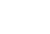

In [59]:
import numpy as np
import matplotlib.pyplot as plt

r = np.linspace(-10.1,10.1,2000)
s,t = np.meshgrid(r,r)

# plot this EXTREMELY small - hack around the fact that you have to actually produce the plot to get the contour
fig = plt.figure(figsize = (0.02,0.02));  # looks like this is as small as you can make the figure without throwing an error, figsize dimensinos can be as small as 0.02 it seems
ax = fig.add_subplot(111);        # panel for original space
ax.axis('off');

# loop over
data = []
contours = []
for i in np.linspace(1,100,200):
    z = s*s + t*t -i
    # to get each contour we must - it seems - actually plot it.  So we plot it completely transparent, and with no axis
    c = ax.contour(s,t,z,colors='k', linewidths=2.0,levels = [0],alpha=0.0)  
    
    # grab points of contour
    p = c.collections[0].get_paths()[0]
    v = p.vertices
    x = v[:,0]
    x.shape = (len(x),1)
    y = v[:,1]
    y.shape = (len(y),1)
    data = np.concatenate((x,y),axis = 1)
    contours.append(data)
    
# save contours as numpy array
contours = np.asarray(contours)
np.save('test_contours',contours)

In [38]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.palettes import Spectral11
output_notebook()

from ipywidgets import interact
import numpy as np

# create figure
p = figure(title="warp it", plot_height=400, plot_width=400, x_range = (-5,5),y_range=(-5,5))

## initialize properties of figure
# p.axis.visible = False
# p.xgrid.grid_line_color = None
# p.ygrid.grid_line_color = None

## initialize contour
contours = np.load('test_contours.npy')
data = contours[0]
x = data[:,0]
y = data[:,1]
r = p.line(x, y, color="#2222aa", line_width=3)

## initialize scatter
d = 10*np.random.rand(200,2) - 5
q = p.circle(d[:,0],d[:,1])

## initialize grid
numlines = 10

# initialize x values
t = np.linspace(-3,3,20)
t.shape = (len(t),1)
c = np.repeat(t,numlines,axis = 1)

# initialize y values
grid = np.random.rand(20,numlines)

# initialize colors - must define for each line
mypalette = Spectral11[0:numlines]   # colors

# initialize multi-line
s = p.multi_line(xs=[v for v in c.T],ys = [g for g in grid.T] , line_color=mypalette, line_width=5)


# update func
def update(f, w=0):
    # update contour
    data = contours[w]
    x = data[:,0]
    y = data[:,1]
    r.data_source.data = dict(x=x, y=y)    
    
    # update scatter
    d = 10*np.random.rand(200,2) - 5
    x = d[:,0]
    y = d[:,1]
    q.data_source.data = dict(x=x, y=y) 
    
    ## update grid
    # update y values
    grid = np.random.rand(200,numlines)
    
    # update mult-line
    s.data_source.data['ys'] = [g for g in grid.T] 
    
    # update figure range
    p.x_range.start = -5 
    p.x_range.end = 5
    p.y_range.start = -5
    p.y_range.end = 5
    
    # obligatory line to plot in notevook
    push_notebook()
    
show(p, notebook_handle=True)

Loading BokehJS ...

In [39]:
interact(update, f=["sin"], w=(0,100,1))

In [35]:
grid

array([[  6.17505326e-01,   2.65221668e-01,   5.46702991e-01,
          1.87230791e-01,   5.31774965e-02,   5.22891351e-01,
          2.05494577e-03,   3.13294875e-01,   9.00154008e-01,
          8.98115030e-01],
       [  2.21364632e-01,   1.61298502e-01,   6.39474777e-02,
          2.97359363e-01,   7.06731628e-01,   7.69215075e-01,
          1.08262923e-01,   1.12426441e-02,   8.44271350e-02,
          3.80990782e-01],
       [  8.11364108e-01,   8.76996927e-01,   1.14495382e-01,
          7.82108878e-01,   4.36997357e-01,   1.53653565e-01,
          5.47492401e-01,   9.67406917e-01,   1.56177518e-01,
          8.48583952e-01],
       [  7.16053758e-01,   6.97355047e-01,   2.29717830e-01,
          5.79796798e-01,   4.88302277e-01,   5.01613666e-01,
          1.29154702e-01,   5.15660388e-01,   4.23312669e-01,
          8.28184123e-02],
       [  7.36778570e-01,   1.92292612e-01,   5.49540915e-01,
          9.44395153e-01,   9.91548773e-01,   4.10093061e-01,
          5.85206519e-01

In [9]:
xv

array([[-3.        , -3.        , -3.        , -3.        , -3.        ,
        -3.        , -3.        , -3.        , -3.        , -3.        ,
        -3.        , -3.        , -3.        , -3.        , -3.        ,
        -3.        , -3.        , -3.        , -3.        , -3.        ,
        -3.        , -3.        , -3.        , -3.        , -3.        ,
        -3.        , -3.        , -3.        , -3.        , -3.        ,
        -3.        , -3.        , -3.        , -3.        , -3.        ,
        -3.        , -3.        , -3.        , -3.        , -3.        ,
        -3.        , -3.        , -3.        , -3.        , -3.        ,
        -3.        , -3.        , -3.        , -3.        , -3.        ,
        -3.        , -3.        , -3.        , -3.        , -3.        ,
        -3.        , -3.        , -3.        , -3.        , -3.        ,
        -3.        , -3.        , -3.        , -3.        , -3.        ,
        -3.        , -3.        , -3.        , -3. 

In [21]:
np.shape(grid)

(100, 10)

In [27]:
a = [e for e in grid.T]

In [28]:
e

array([ 0.71004324,  0.79815928,  0.17980593,  0.1843918 ,  0.18712933,
        0.50681165,  0.03638061,  0.60244653,  0.99163626,  0.37015227,
        0.21888271,  0.93542859,  0.48743681,  0.22381102,  0.0926051 ,
        0.69324922,  0.3690993 ,  0.65377598,  0.70781508,  0.79079373,
        0.08776688,  0.6283469 ,  0.54252162,  0.33332374,  0.03183569,
        0.7644118 ,  0.87154561,  0.54991605,  0.84591897,  0.56997512,
        0.97152409,  0.5263948 ,  0.38126689,  0.71921087,  0.45153047,
        0.30377124,  0.8249223 ,  0.68325223,  0.63339209,  0.98899278,
        0.7363216 ,  0.27613787,  0.527301  ,  0.29287482,  0.80010746,
        0.58553434,  0.46325026,  0.65100004,  0.82536842,  0.14553241,
        0.10701769,  0.56895846,  0.65701285,  0.51793696,  0.04614984,
        0.92558959,  0.84123288,  0.79612038,  0.00211513,  0.85642165,
        0.31778316,  0.71079543,  0.69552792,  0.27462427,  0.75877669,
        0.51894517,  0.81867117,  0.93552456,  0.46632461,  0.36

In [18]:
c

array([[ 0.        ,  0.        ],
       [ 0.01010101,  0.01010101],
       [ 0.02020202,  0.02020202],
       [ 0.03030303,  0.03030303],
       [ 0.04040404,  0.04040404],
       [ 0.05050505,  0.05050505],
       [ 0.06060606,  0.06060606],
       [ 0.07070707,  0.07070707],
       [ 0.08080808,  0.08080808],
       [ 0.09090909,  0.09090909],
       [ 0.1010101 ,  0.1010101 ],
       [ 0.11111111,  0.11111111],
       [ 0.12121212,  0.12121212],
       [ 0.13131313,  0.13131313],
       [ 0.14141414,  0.14141414],
       [ 0.15151515,  0.15151515],
       [ 0.16161616,  0.16161616],
       [ 0.17171717,  0.17171717],
       [ 0.18181818,  0.18181818],
       [ 0.19191919,  0.19191919],
       [ 0.2020202 ,  0.2020202 ],
       [ 0.21212121,  0.21212121],
       [ 0.22222222,  0.22222222],
       [ 0.23232323,  0.23232323],
       [ 0.24242424,  0.24242424],
       [ 0.25252525,  0.25252525],
       [ 0.26262626,  0.26262626],
       [ 0.27272727,  0.27272727],
       [ 0.28282828,